## Logistic Regression Plots: timeplots, binned residuals and odds ratio uncertainty

#### The goal of the notebook is to produce interesting plots for logistic regression models. This includes ploting coefficients over time, binning residuals in order to identify issues in the behaviour of the model residuals and a plot of odds ratios which gauges the uncertainty of the estimates. 

#### I have taken the data from the GSS survey and have processed it using R. The dependent variable in the below models is an indicators for respondents who were 'happy' at the time of taking the survey. Additional regressors include income category, ethnicity, identifying as religious, mean centred age and years of eduction, having children and employment status. 


In [16]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
import math

In [8]:
data = pd.read_csv(r"../logistic_regression_plots/gss_data.csv")
data.columns = map(str.lower, data.columns)
X = data[['female','white', 'income_bound', 'religious','c_age','educ','have_children','ft_employed','pt_employed','retired','in_education','home_maker','work_status_other']]


yrs = [1991, 1993, 1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016]
var_names = ["intercept", "female", "white","income", "religious", "age","education","children", "ft_employed","pt_employed","retired", "in_education", "homemaker","work_status_other"]


form = 'happy ~ female + white + income_bound + religious + c_age + educ + have_children + ft_employed + pt_employed + retired + in_education + home_maker + work_status_other'

def yearly_stats(data, yrs, variable_names, formula):
    ''' Estimates a logistic regression model over yearly subsets of the data
    and returns two dataframes containing the respective coefficients and standard errors'''
    
    coef = []
    se = []
    for i in yrs:
        print(i)
        mod = smf.logit(formula = formula, 
                        subset = (data.year==i), data=data).fit()
        coef.append((i,*mod.params))
        se.append((i,*mod.bse))

    return pd.DataFrame(coef, columns=('yrs',*variable_names)).set_index('yrs'), pd.DataFrame(se, columns=('yrs',*variable_names)).set_index('yrs')

def plotter(coef, se):
    '''Plots a grid of coefficients and standard errors for each variable over time''' 
    
    #TO DO: Get rid of empty plots
    fig, ax = plt.subplots(nrows=4,ncols=4, squeeze=False)
    fig.set_figheight(18)
    fig.set_figwidth(15)
    for col, ax in zip(coef.columns, ax.flatten()):
        #ax.plot(c.index, c[col])
        ax.errorbar(coef.index, coef[col], yerr=se[col], fmt='o', markersize='5', elinewidth=1)
        ax.set_title(col, fontsize=20)
        ax.set_xticks(np.arange(min(coef.index), max(coef.index)+1, 12))
        ax.tick_params(axis='both', labelsize=15)
        ax.axhline(0, c='black', linewidth=1,linestyle='--')
    #ax[3,2].set_visible(False)
    #fig.delaxes(ax[3,2])
    fig.tight_layout()
    #fig.set_size_inches(20,10)
    

In [9]:
coefs, se = yearly_stats(data=data, yrs=yrs, variable_names = var_names, formula=form)

1991
Optimization terminated successfully.
         Current function value: 0.318563
         Iterations 7
1993
Optimization terminated successfully.
         Current function value: 0.333984
         Iterations 7
1994
Optimization terminated successfully.
         Current function value: 0.341921
         Iterations 6
1996
Optimization terminated successfully.
         Current function value: 0.344681
         Iterations 7
1998
Optimization terminated successfully.
         Current function value: 0.337530
         Iterations 7
2000
Optimization terminated successfully.
         Current function value: 0.307803
         Iterations 7
2002
Optimization terminated successfully.
         Current function value: 0.343901
         Iterations 7
2004
Optimization terminated successfully.
         Current function value: 0.363252
         Iterations 6
2006
Optimization terminated successfully.
         Current function value: 0.358899
         Iterations 6
2008
Optimization terminated successf

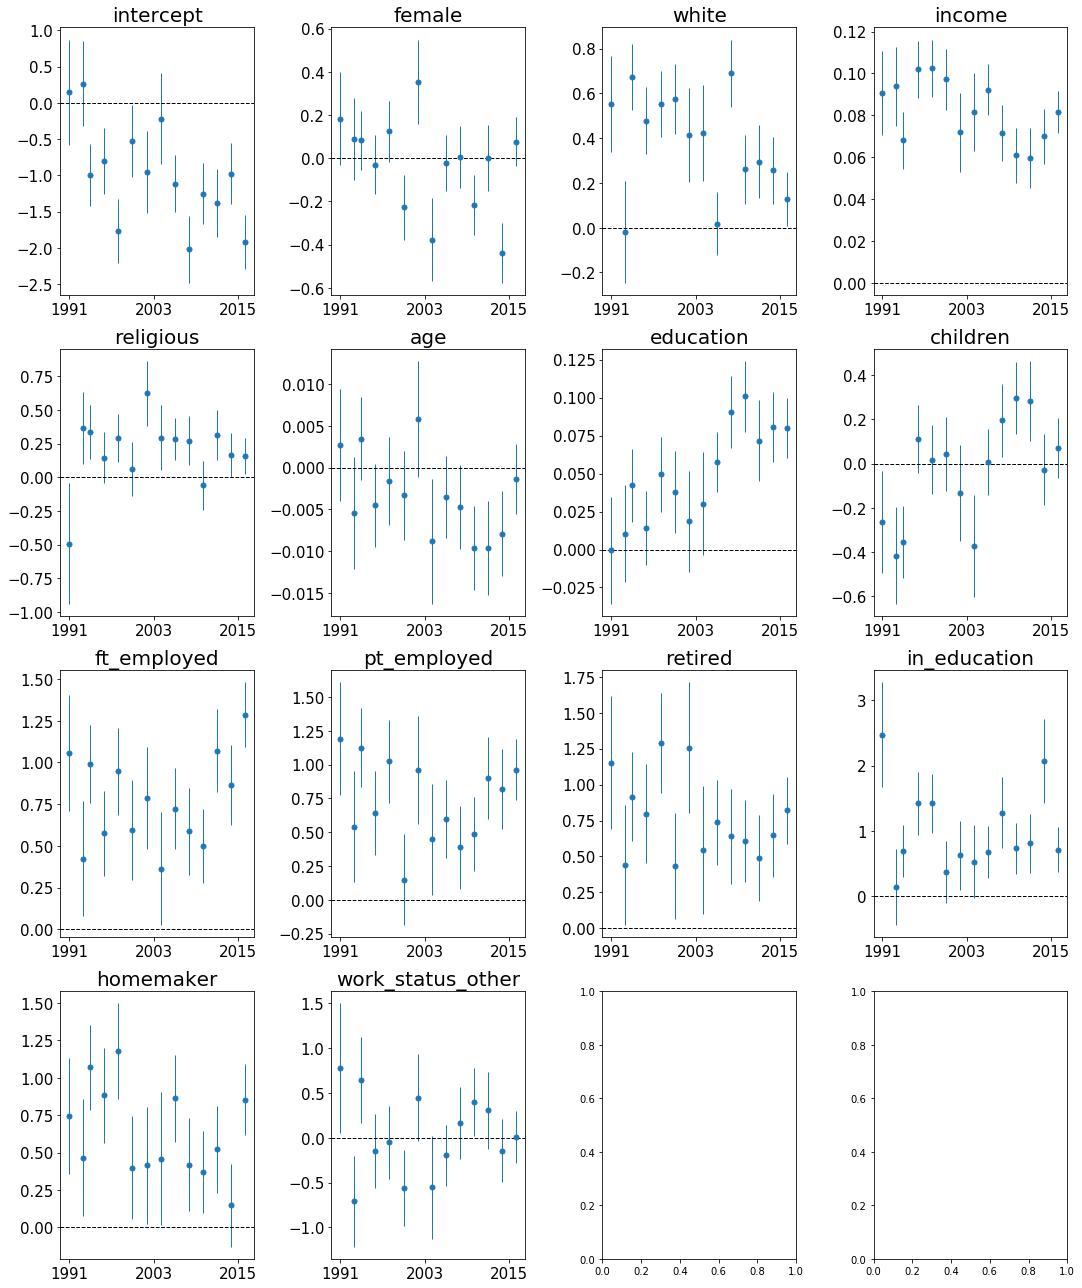

In [10]:
plotter(coefs,se)

In [11]:
model = smf.logit(formula = form, data=data).fit()
model_pred = np.array(model.predict(X))


def binned_residuals(x, y, n_class=None):
    
    if n_class is None:
        n_class = np.sqrt(len(x))
    
    if isinstance(x, np.ndarray):
        pass
    else:
        x = np.array(x)
        
    output = []
    breaks_idx = np.int_(np.floor(len(x)*(np.arange(1, n_class,1)/n_class)))
    breaks = np.insert(np.append(np.sort(x)[breaks_idx], float('inf')),0,float('-inf'))
    x_binned = pd.cut(x, bins=breaks, labels=False)
    
    for i in range(0,n_class):
        items = np.arange(0, len(x),1)[x_binned==i]
        x_lo = np.min(x[items])
        x_hi = np.max(x[items])
        xbar = np.mean(x[items])
        ybar = np.mean(y[items])
        n = len(items)
        sdev = np.std(y[items])
        output.append((xbar, ybar, n, x_lo, x_hi, 2*sdev/np.sqrt(n)))

    return pd.DataFrame(output, columns=('xbar','ybar', 'n', 'xlo', 'xhi', '2se'))

def plot_binned_residuals(df, x_lab):
    plt.scatter(df['xbar'], df['ybar'], color='black', s=2)
    plt.plot(df['xbar'], df['2se'], color='grey', linewidth=0.5)
    plt.plot(df['xbar'], -1*df['2se'], color='grey',linewidth=0.5)
    plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    plt.xlabel(x_lab)
    plt.ylabel("Average Resid")
    plt.title("Binned Residual Plot")

Optimization terminated successfully.
         Current function value: 0.362773
         Iterations 6


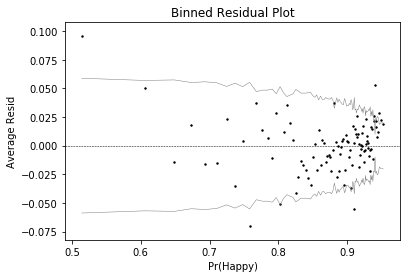

In [12]:
plot_binned_residuals(binned_residuals(model_pred, data['happy']-model_pred, n_class=100), x_lab='Pr(Happy)')

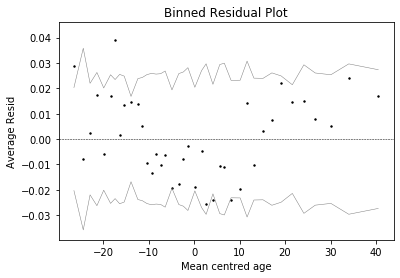

In [13]:
plot_binned_residuals(binned_residuals(data['c_age'], data['happy']-model_pred, n_class=40), x_lab='Mean centred age')

In [14]:
def plot_odds_ratios(model_params, model_std_errors, return_df=False):
    '''Plots odd ratios with error bars reflecting 90%, 95% and 99% confidence intervals '''
    z_90 = 1.645
    z_95 = 1.96
    z_99 = 2.576
    
    df = pd.DataFrame([model_params.T,model_std_errors.T]).T
    df = df.reset_index()
    df.columns  = ['variable', 'coef', 'se']
    df['odds'] = df.coef.apply(lambda x: np.exp(x))
    
    #in this circumstance, CI's are not symmetric around the point estimate, this is not elegant but works for now
    
    df['90pc_ci_l'] = df['odds'] - np.exp(df['coef']-(df['se']*z_90))
    df['90pc_ci_h'] = np.exp(df['coef']+(df['se']*z_90)) - df['odds']
    
    df['95pc_ci_l'] = df['odds'] - np.exp(df['coef']-(df['se']*z_95))
    df['95pc_ci_h'] = np.exp(df['coef']+(df['se']*z_95)) - df['odds'] 
    
    df['99pc_ci_l'] = df['odds'] - np.exp(df['coef']-(df['se']*z_99))
    df['99pc_ci_h'] = np.exp(df['coef']+(df['se']*z_99)) - df['odds'] 
    
    
    plt.errorbar(df['odds'],df['variable'],xerr=(df['90pc_ci_l'],df['90pc_ci_h']), fmt='o', c = 'black')
    plt.errorbar(df['odds'],df['variable'],xerr=(df['95pc_ci_l'],df['95pc_ci_h']), fmt='o', c = 'black', alpha=0.5)
    plt.errorbar(df['odds'],df['variable'],xerr=(df['99pc_ci_l'],df['99pc_ci_h']), fmt='o', c = 'black', alpha=0.2)
    plt.axvline(x=1, color='black', linestyle='--', linewidth=0.5)
    plt.title("Odds Ratios")
    plt.show()
    
    if return_df:
        return df
    else:
        pass


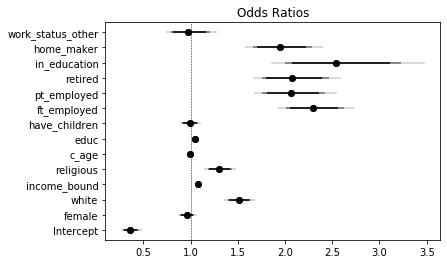

In [15]:
plot_odds_ratios(model_params=model.params, model_std_errors=model.bse)